In [1]:
from scipy.io.wavfile import read as read_wav
from IPython.display import Audio
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import librosa as lr
import seaborn as sn
import pandas as pd
import numpy as np
import scipy
import pydub
import os

In [2]:
genres = {
    'disco': 0,
    'country': 1,
    'jazz': 2,
    'classical': 3,
    'blues': 4,
    'hiphop': 5,
    'metal': 6,
    'rock': 7,
    'pop': 8,
    'reggae': 9
}

In [3]:
hparams = {
    'samplerate': 22050,
    'seq_length': 256,
    'hop_length': 512,
    'fft_window': 2048
}

In [4]:
def extract_features(filepath, hparams):
    
    audio_data_array = lr.load(filepath, sr=hparams['samplerate'], mono=True)
    
    # normalized = lr.util.normalize(audio_data_array[0])
    
    features = [
        
        # MFCC Features:
        lr.feature.mfcc(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),

        # Chroma STFT:
        lr.feature.chroma_stft(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),
        
        # Spectral Centroid:
        lr.feature.spectral_centroid(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),
        
        # Spectral Contrast:
        lr.feature.spectral_contrast(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        )
    ]
    
    return np.vstack(features)

In [5]:
lstm_1_model = tf.keras.models.load_model('LSTM-1/models/model')
lstm_2a_model = tf.keras.models.load_model('LSTM-2a/models/model')
lstm_2b_model = tf.keras.models.load_model('LSTM-2b/models/model')
lstm_3a_model = tf.keras.models.load_model('LSTM-3a/models/model')
lstm_3b_model = tf.keras.models.load_model('LSTM-3b/models/model')
lstm_3c_model = tf.keras.models.load_model('LSTM-3c/models/model')
lstm_3d_model = tf.keras.models.load_model('LSTM-3d/models/model')

In [6]:
def lookup(arr):
    if arr == [0, 0, 0]:
        return 'hiphop'
    elif arr == [0, 0, 1]:
        return 'metal'
    elif arr == [0, 0, 2]:
        return 'rock'
    elif arr == [0, 1, 0]:
        return 'pop'
    elif arr == [0, 1, 1]:
        return 'reggae'
    elif arr == [1, 0, 0]:
        return 'disco'
    elif arr == [1, 0, 1]:
        return 'country'
    elif arr == [1, 1, 0]:
        return 'jazz'
    elif arr == [1, 1, 1]:
        return 'classical'
    else:
        return 'blues'

In [7]:
def predict(features, nseg, hparams):
    
    result = []
    
    lstm_1_res_arr = []
    for i in range(nseg):
        lstm_1_res_arr += [np.argmax(
            lstm_1_model.predict(
                np.moveaxis(
                    features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                ).reshape(1, 256, 40)
            )
        )]

    lstm_1_res = list(Counter(lstm_1_res_arr))[0]    
    result += [lstm_1_res]
    
    # strong classes:
    if lstm_1_res == 0:
        
        lstm_2a_res_arr = []
        for i in range(nseg):
            lstm_2a_res_arr += [np.argmax(
                lstm_2a_model.predict(
                    np.moveaxis(
                        features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                    ).reshape(1, 256, 40)
                )
            )]

        lstm_2a_res = list(Counter(lstm_2a_res_arr))[0]
        
        result += [lstm_2a_res]
        
        # substrong-1:
        if lstm_2a_res == 0:
            
            lstm_3a_res_arr = []
            for i in range(nseg):
                lstm_3a_res_arr += [np.argmax(
                    lstm_3a_model.predict(
                        np.moveaxis(
                            features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                        ).reshape(1, 256, 40)
                    )
                )]

            lstm_3a_res = list(Counter(lstm_3a_res_arr))[0]
        
            result += [lstm_3a_res]
            
        # substrong-2:
        else:
            
            lstm_3b_res_arr = []
            for i in range(nseg):
                lstm_3b_res_arr += [np.argmax(
                    lstm_3b_model.predict(
                        np.moveaxis(
                            features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                        ).reshape(1, 256, 40)
                    )
                )]

            lstm_3b_res = list(Counter(lstm_3b_res_arr))[0]

            result += [lstm_3b_res]
            
    # mild classes:
    else:
        
        lstm_2b_res_arr = []
        for i in range(nseg):
            lstm_2b_res_arr += [np.argmax(
                lstm_2b_model.predict(
                    np.moveaxis(
                        features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                    ).reshape(1, 256, 40)
                )
            )]

        lstm_2b_res = list(Counter(lstm_2b_res_arr))[0]
        
        result += [lstm_2b_res]
        
        
        # submild-1:
        if lstm_2b_res == 0:
            
            lstm_3c_res_arr = []
            for i in range(nseg):
                lstm_3c_res_arr += [np.argmax(
                    lstm_3c_model.predict(
                        np.moveaxis(
                            features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                        ).reshape(1, 256, 40)
                    )
                )]

            lstm_3c_res = list(Counter(lstm_3c_res_arr))[0]            
            result += [lstm_3c_res]
            
        # submild-2:
        else:
            
            lstm_3d_res_arr = []
            for i in range(nseg):
                lstm_3d_res_arr += [np.argmax(
                    lstm_3d_model.predict(
                        np.moveaxis(
                            features[:, i * hparams['seq_length']:(i+1) * hparams['seq_length']], 0, 1
                        ).reshape(1, 256, 40)
                    )
                )]

            lstm_3d_res = list(Counter(lstm_3d_res_arr))[0]            
            result += [lstm_3d_res]
            
    return lookup(list(result))

### Accuracy on GTZAN Validation and Test Set:

In [8]:
confusion_mat = np.zeros(shape=(10, 10))

In [9]:
for genre in os.listdir('dataset/'):
    
    filelist = os.listdir('./dataset/' + genre)
    
    print('===================================')
    print('Original Genre: ', genre)
    for i in range(90, 100, 1):
        features = extract_features('dataset/' + genre + '/' + filelist[i], hparams)
        nseg = features.shape[1] // 256
        result = predict(features, nseg, hparams)
        
        if result == genre:
            confusion_mat[genres[genre]][genres[genre]] += 1
        else:
            confusion_mat[genres[genre]][genres[result]] += 1

Original Genre:  pop
Original Genre:  jazz
Original Genre:  reggae
Original Genre:  disco
Original Genre:  blues
Original Genre:  hiphop
Original Genre:  rock
Original Genre:  metal
Original Genre:  classical
Original Genre:  country


In [10]:
confusion_dataframe = pd.DataFrame(
    data=confusion_mat,
    index=list(genres.keys()),
    columns=list(genres.keys())
)

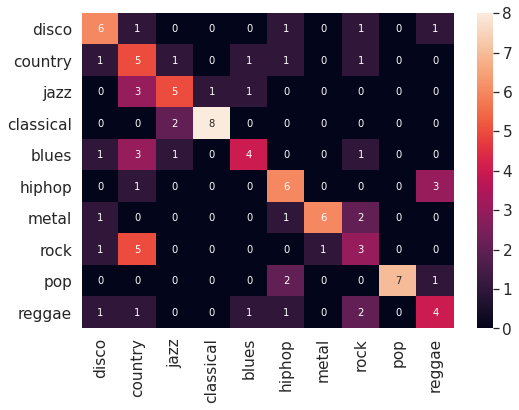

In [12]:
fig = plt.figure(figsize=(8, 6))

sn.set(font_scale=1.4) # for label size
sn.heatmap(confusion_dataframe, annot=True, annot_kws={"size": 10})

fig.tight_layout()
plt.show()

In [14]:
accuracy = 100 * (np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat))
print('Accuracy: {} %'.format(accuracy))

Accuracy: 54.0 %
